In [407]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [417]:
I = 30         # iterations
N_CARS = 25    # percentage of cars
N_PEDS = 75    # percentage of pedestrians

## Percentage of Evacuated

In [377]:
total_dfs = []
cars_dfs = []
peds_dfs = []

for i in range(1, I + 1):
    data = pd.read_csv(f"./data/evacuated/evacuated-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)

    tot_evac = data[['x', 'y']].copy()
    tot_evac["i"] = i
    #tot_evac["cat"] = "evacuated"

    cars_evac = data[['x.1', 'y.1']].copy()
    cars_evac["i"] = i
    #cars_evac["cat"] = "cars"
    #cars_evac = cars_evac.rename(columns={'x.1':'x', 'y.1':'y'})

    peds_evac = data[['x.2', 'y.2']].copy()
    peds_evac["i"] = i
    #peds_evac["cat"] = "pedestrians"
    #peds_evac = peds_evac.rename(columns={'x.2':'x', 'y.2':'y'})

    # xx = pd.concat([tot_evac, cars_evac, peds_evac])

    #total_dfs.append(xx)

    total_dfs.append(tot_evac)
    cars_dfs.append(cars_evac)
    peds_dfs.append(peds_evac)

t_df = pd.concat(total_dfs).reset_index() # drop=True
c_df = pd.concat(cars_dfs).reset_index()
p_df = pd.concat(peds_dfs).reset_index()

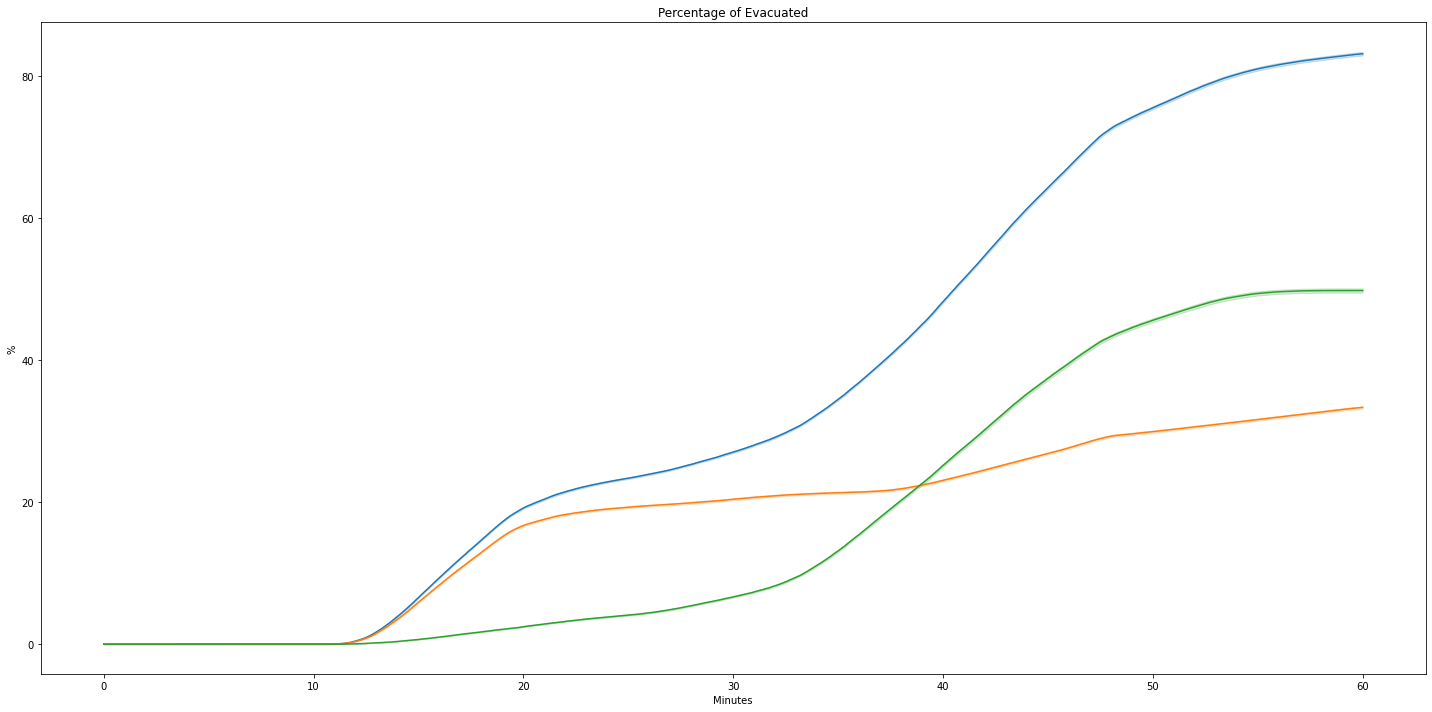

In [378]:
fig = plt.figure(figsize=(20, 10))
ax = sns.lineplot(x=t_df["x"], y=t_df["y"]) #  hue=t_df["cat"]
ax.set_title("Percentage of Evacuated")
ax.set_xlabel("Minutes")
ax.set_ylabel("%")
sns.lineplot(x=c_df["x.1"], y=c_df["y.1"])
sns.lineplot(x=p_df["x.2"], y=p_df["y.2"])
fig.tight_layout()

### Compare between configurations grouping by cars/pedestrias

## Evacuation Times

In [380]:
# averaged times
df = pd.DataFrame({"y" : [0] * 60}, index=range(1, 61))

for i in range(1, I + 1):
    data = pd.read_csv(f"./data/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data = data.reindex(range(1, 61), fill_value=0)
    df = df + data

df = df / I
df = df.reset_index()
df.columns=["x", "y"]

In [381]:
# confidence interval
df = []
for i in range(1, I + 1):
    data = pd.read_csv(f"./data/times/times-{N_PEDS}-{N_CARS}-{i}.csv", skiprows=18)
    data = data[['x', 'y']].set_index("x")
    data['i'] = i
    data = data.reindex(range(1, 61), fill_value=0)
    df.append(data)
    
df = pd.concat(df).reset_index()

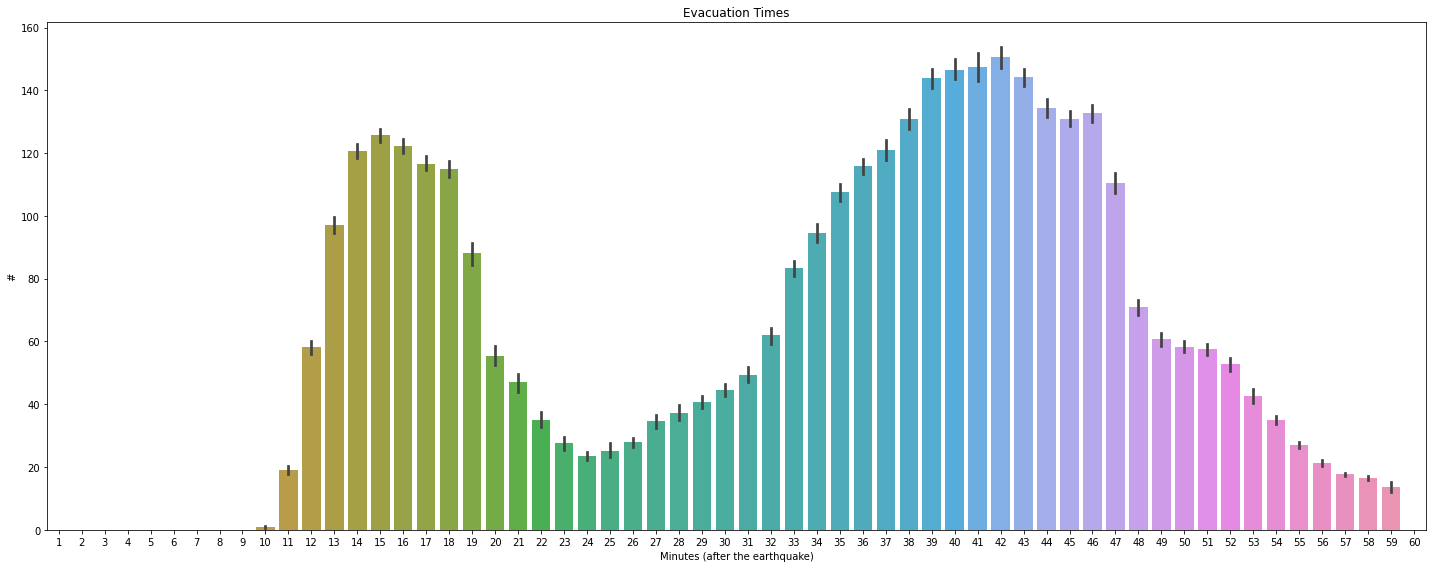

In [382]:
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x=df['x'], y=df['y'])
ax.set_title("Evacuation Times")
ax.set_xlabel("Minutes (after the earthquake)")
ax.set_ylabel("#")
fig.tight_layout()

## Network Data

### Average Values

In [414]:
import re

LIST_RE = re.compile(r"\[(\d+) (\d+(?:\.\d+)?)\]")


def parse_list(netlogo_list):
    x = LIST_RE.findall(netlogo_list)
    x = dict(map(list, x))

    return x


def to_netlogo(value):
    return "[" + " ".join([f"[{k} {v}]" for (k, v) in value.items()]) + "]" 


def average_netlogo_lists(lists):
    lists = list(map(parse_list, lists))
    
    # append values of the same intersection
    new_dict = {}
    for n in lists:
        for (key, value) in n.items():
            if key not in new_dict:
                new_dict[key] = []

            new_dict[key].append(float(value))

    # pad values if missing and replace values with the mean
    for (key, value) in new_dict.items():
        new_dict[key] = np.mean((np.pad(value, (0, I - len(value)))))

    return to_netlogo(new_dict)

In [419]:
prefix = f"./data/intersections/intersections-{N_PEDS}-{N_CARS}"

ints_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["who", "minute"])

    ints_df = pd.concat((ints_df, data))

grouped_ints_df = ints_df.groupby(level=[0, 1])

# average values 

avg_ints_df = pd.DataFrame(grouped_ints_df["car-delay"].mean())

for col in set(ints_df.columns) - set(["car-delay"]):
    avg_list = grouped_ints_df[col].apply(lambda x: average_netlogo_lists(x))
    avg_ints_df = avg_ints_df.join(avg_list)

avg_ints_df.to_csv(f"{prefix}-mean.csv")

In [426]:
prefix = f"./data/intersections/intersections-evtimes-{N_PEDS}-{N_CARS}"

ints_evtime_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["who"])

    ints_evtime_df = pd.concat((ints_evtime_df, data))

ints_evtime_df = ints_evtime_df.groupby(level=[0]).mean()
ints_evtime_df.to_csv(f"{prefix}-mean.csv")

In [428]:
prefix = f"./data/roads/roads-{N_PEDS}-{N_CARS}"

roads_df = None
for i in range (1, I + 1):
    data = pd.read_csv(f"{prefix}-{i}.csv")
    data = data.set_index(["end1", "end2", "minute"])

    roads_df = pd.concat((roads_df, data))

roads_df = roads_df.groupby(level=[0, 1, 2]).mean()

roads_df.to_csv(f"{prefix}-mean.csv")

### Casualties

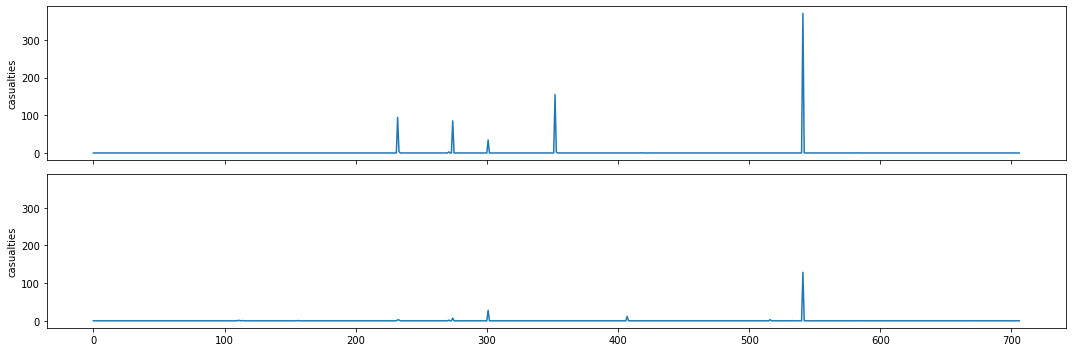

In [529]:
exps = [
    { "N_PEDS": 50, "N_CARS": 50 },
    { "N_PEDS": 75, "N_CARS": 25 },
]

fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True, sharey=True)

for i, exp in enumerate(exps):
    data = pd.read_csv(f"./data/roads/roads-{exp['N_PEDS']}-{exp['N_CARS']}-mean.csv")

    ints = set(data["end1"]).union(set(data["end2"]))

    data = data.set_index(["end1", "end2"])
    data = data.loc[data["minute"] == 60]


    for x in ints:
        for y in ints:   
            if (x, y) in data.index and (y, x) in data.index:
                data.loc[(x, y)] = data.loc[(x, y)] + data.loc[(y, x)]
                data.drop((y, x), inplace=True)

    data = data.reset_index()
    
    sns.lineplot(data["casualties"], ax=ax[i])

fig.tight_layout()